# Load libraries and set figures parameters

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Figures parameters
sns.set()
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')

# Import dataset and sub-sampling

In [3]:
# Import Datasets
data_stackoverflow = pd.read_csv('QueryResults.csv', low_memory=False)
print(f'data_stackoverflow: {data_stackoverflow.shape}')

data_stackoverflow: (50000, 10)


Minimun View: 2
Maximun View: 166827
Median of View: 46.0


Text(46, -0.42, 'Médiane')

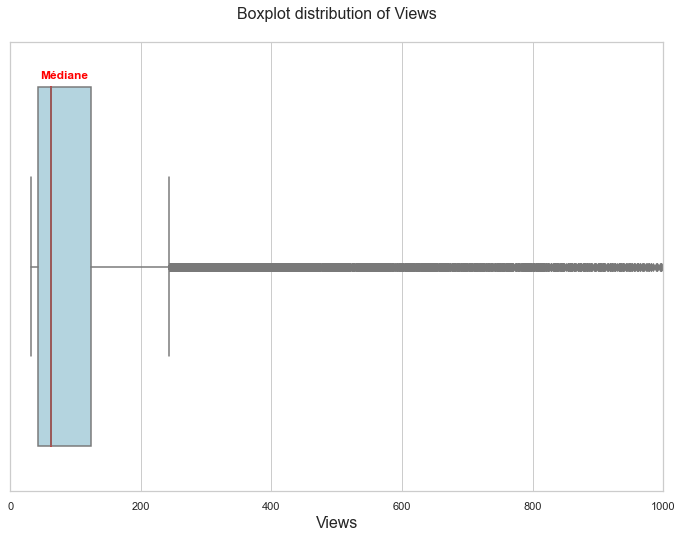

In [4]:
# Analyze the View count and choose a threshold for the number of views

print(f'Minimun View: {data_stackoverflow.ViewCount.min()}')
print(f'Maximun View: {data_stackoverflow.ViewCount.max()}')
print(f'Median of View: {data_stackoverflow.ViewCount.median()}')

data_stackoverflow = data_stackoverflow[data_stackoverflow['ViewCount']>30]
data_stackoverflow.shape
        # The results with the minimum, maximum and median view shows that a question with more than 30 view is relevant


# Boxplot for the number of views
p = sns.boxplot(x=data_stackoverflow['ViewCount'], color = "lightblue")

p.set_title("Boxplot distribution of Views\n", fontsize=16)
p.axvline(x=data_stackoverflow['ViewCount'].median(), color = 'red', lw=2,  ymin=0.1, ymax=0.9)
p.set_xlabel ("Views", fontsize=16)
p.set_ylabel ("", fontsize=16)
p.set_xlim(0, 1000)
p.text(46, -0.42, "Médiane", horizontalalignment='left', size=12, color='red', weight='semibold')

(0.0, 1500.0)

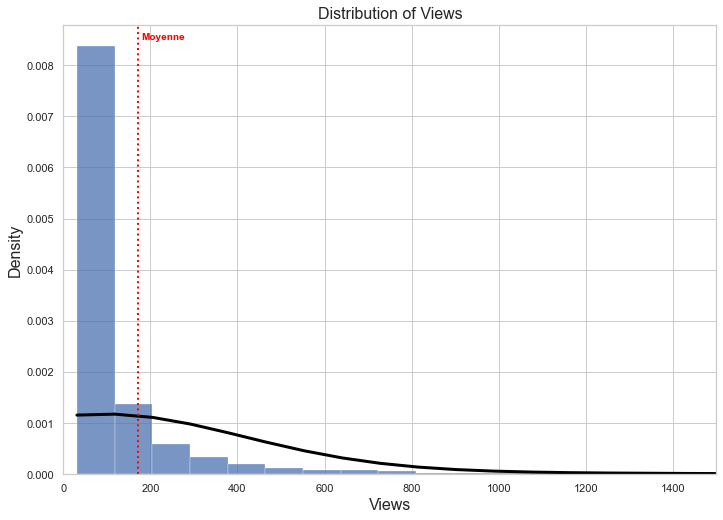

In [5]:
# Select data with more than 30 views 

data_stackoverflow = data_stackoverflow[data_stackoverflow['ViewCount']>=30]

# Then I took a sample of 5000 row in order to encode fatser the Text Data
# Only keep the columns 'Title', 'Tags' and 'ViewCount'.
df_sample = data_stackoverflow.iloc[:5000,[-6, -5, -4]].reset_index().drop(['index'], axis=1)


# Views distribution after sampling
q = sns.histplot(x=df_sample['ViewCount'], bins=200, stat = "density")
ax= sns.kdeplot(x=df_sample['ViewCount'], bw_adjust=3, cut=0, color = "black", lw=3)

q.text(180, 0.0085, "Moyenne", horizontalalignment='left', size=10, color='red', weight='semibold')
q.axvline(x=df_sample['ViewCount'].mean(), color = 'red', lw=2, linestyle='dotted')
q.set_title('Distribution of Views', fontsize=16)
q.set_xlabel ('Views', fontsize=16)
q.set_ylabel ('Density', fontsize=16)
q.set_xlim(0, 1500)

In [6]:
# Show the data frame
df_sample.head()

Title  \
0  Grouping XML nodes based on the first element ...   
1  Connection error with SQL Server 2012 with Python   
2  I can't view WhatsApp media images in WhatsApp...   
3        How to use laravel-vue-pagination in Vue 3?   
4  Is this code clean (using policies, resources,...   

                                      Tags  ViewCount  
0                    <xml><xslt><grouping>         36  
1  <python><sql-server><python-3.x><linux>         85  
2  <android><image><filesystems><whatsapp>         69  
3             <javascript><vue.js><vuejs3>        552  
4                                <laravel>         34

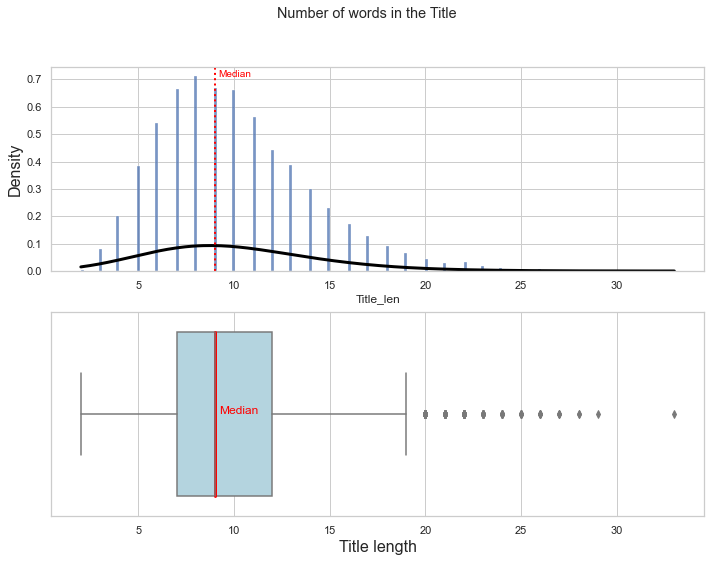

In [7]:
# Calculate the text length for the column Title in order to check if the length of the text 
# in the title is sufficient to apply the templates.
df_sample['Title_len'] = df_sample['Title'].apply(lambda x: len(x.split()))


# Distribution of the number of words in the titles
fig, axes = plt.subplots(2, 1)
fig.suptitle("Number of words in the Title")

# Title length distribution
q = sns.histplot(ax = axes[0], x=df_sample['Title_len'], bins=200, stat = 'density')
ax= sns.kdeplot(ax = axes[0], x=df_sample['Title_len'], bw_adjust=3, cut=0, color = 'black', lw=3)
q.text(9.2, 0.71, 'Median', horizontalalignment='left', size=10, color='red')
q.axvline(x=df_sample['Title_len'].median(), color = 'red', lw=2, linestyle='dotted')
p.set_xlabel ('', fontsize=16)
q.set_ylabel ('Density', fontsize=16)

# Boxplot for the number of views
p = sns.boxplot(ax = axes[1], x=df_sample['Title_len'], color = 'lightblue')
p.axvline(x=df_sample['Title_len'].median(), color = 'red', lw=3,  ymin=0.1, ymax=0.9)
p.text(9.2, 0, 'Median', horizontalalignment='left', size=12, color='red')
p.set_xlabel ('Title length', fontsize=16)
p.set_ylabel ('', fontsize=16)
        # 75% of the titles presnet more than 6 words.

# Drop the colimn Title length
df_sample = df_sample.drop(['Title_len'], axis=1)

The figures show that 75% of the titles present more than 7 words. Moreover, taking into consideration that the title summarizes the underlying text and that it often presents keywords, this allows us to conclude that the title is relevant and sufficient to apply the templates. 

# Remove punctuation and extract all the noun in the Title

Here, I perform a simple preprocessing on the content of Title column to make them more amenable for analysis, and reliable results. To do that, I’ll use a regular expression to remove any punctuation.

In [8]:
# Load the regular expression library
import re

# Remove punctuation
df_sample['Title_processed'] = df_sample['Title'].map(lambda x: re.sub('[,\.!?]', ' ', x))


Here, I will delete everything except the names. Indeed, the names (like Python, Windows, Google etc.) are the most relevant and informative to propose tags.

In [9]:
import nltk

def extract_NN(sent):
    grammar = r"""
    
    NP:
        {<NNP>} # proper noun, singular ex. 'Dupont'
        {<NNPS>} # proper noun, plural ex. 'Americans'                      
    """
    chunker = nltk.RegexpParser(grammar)
    ne = []
    chunk = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
    for tree in chunk.subtrees(filter=lambda t: t.label() == 'NP'):
        ne.append(' '.join([child[0] for child in tree.leaves()]))
    return ne


df_sample['Title_extracted'] = df_sample.Title_processed.apply(extract_NN)
df_sample.head(5)

Title  \
0  Grouping XML nodes based on the first element ...   
1  Connection error with SQL Server 2012 with Python   
2  I can't view WhatsApp media images in WhatsApp...   
3        How to use laravel-vue-pagination in Vue 3?   
4  Is this code clean (using policies, resources,...   

                                      Tags  ViewCount  \
0                    <xml><xslt><grouping>         36   
1  <python><sql-server><python-3.x><linux>         85   
2  <android><image><filesystems><whatsapp>         69   
3             <javascript><vue.js><vuejs3>        552   
4                                <laravel>         34   

                                     Title_processed  \
0  Grouping XML nodes based on the first element ...   
1  Connection error with SQL Server 2012 with Python   
2  I can't view WhatsApp media images in WhatsApp...   
3        How to use laravel-vue-pagination in Vue 3    
4  Is this code clean (using policies  resources ...   

                          Title_extracted  
0                                   [XML]  
1       [Connection, SQL, Server, Python]  
2  [WhatsApp, WhatsApp, Private, Gallery]  
3                                   [Vue]  
4                                      []

# Tokenize and Lemmatize words

Let’s tokenize and lemmatize each sentence into a list of words and remove unnecessary characters altogether.

In [10]:
import gensim
from gensim.utils import simple_preprocess
from nltk.stem.wordnet import WordNetLemmatizer

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_sample.Title_extracted.tolist()
data_words = list(sent_to_words(data))


def Titles_preprocessor(Titles):
    
    # Lemmatize all words
    lemmatizer = WordNetLemmatizer()
    Titles = [[lemmatizer.lemmatize(token) for token in doc] for doc in Titles]
    return Titles

data_words = Titles_preprocessor(data_words)
print(data_words[:10])

[['xml'], ['connection', 'sql', 'server', 'python'], ['whatsapp', 'whatsapp', 'private', 'gallery'], ['vue'], [], ['test'], [], [], ['blade'], ['cors', 'adminlte']]


# Remove Stopwords

In [11]:
# Let’s define the functions to remove the stopwords.
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 
                   'get', 'make', 'go', 'know', 'take', 'see', 'come', 'think', 
                   'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work',
                   'seem', 'feel', 'try', 'leave', 'call', 'may'])

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Comparison before and after text data processing of column 'Title'.

In [12]:
print('The first 10 Titles before and after processing:')
for i in range(0,5):
    print(f'{i+1}) {df_sample.Title[i]}')
    print(f'{i+1}) {data_words_nostops[i]}\n')

The first 10 Titles before and after processing:
1) Grouping XML nodes based on the first element value in each node using XSLT
1) ['xml']

2) Connection error with SQL Server 2012 with Python
2) ['connection', 'sql', 'server', 'python']

3) I can't view WhatsApp media images in WhatsApp Private folder and Gallery
3) ['whatsapp', 'whatsapp', 'private', 'gallery']

4) How to use laravel-vue-pagination in Vue 3?
4) ['vue']

5) Is this code clean (using policies, resources, form validation)
5) []



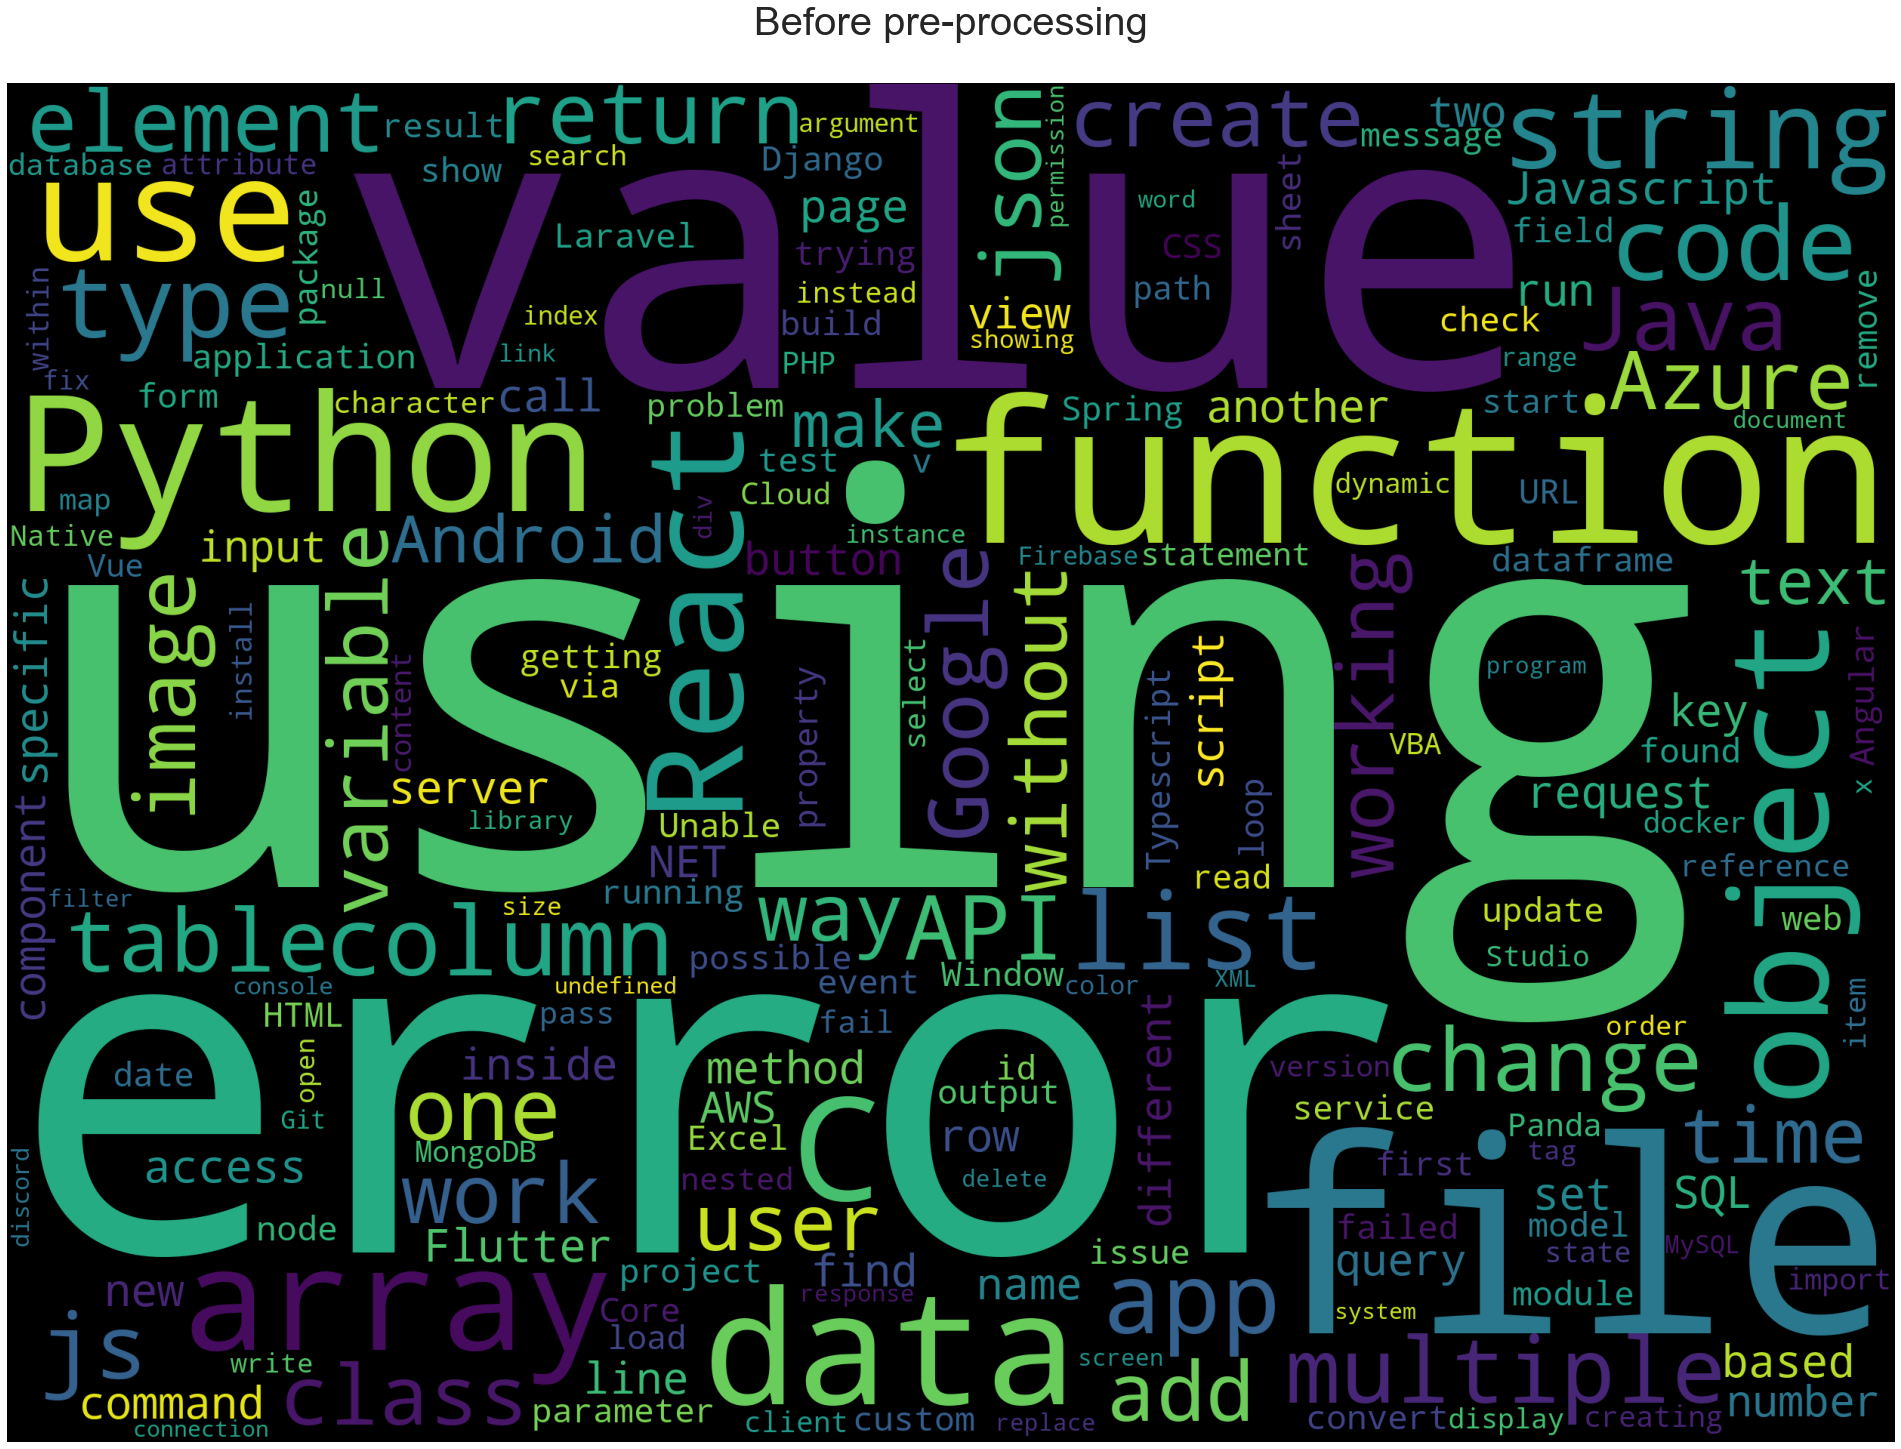

In [13]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

text = df_sample.Title.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title('Before pre-processing\n',fontsize=40)
plt.imshow(cloud_toxic)

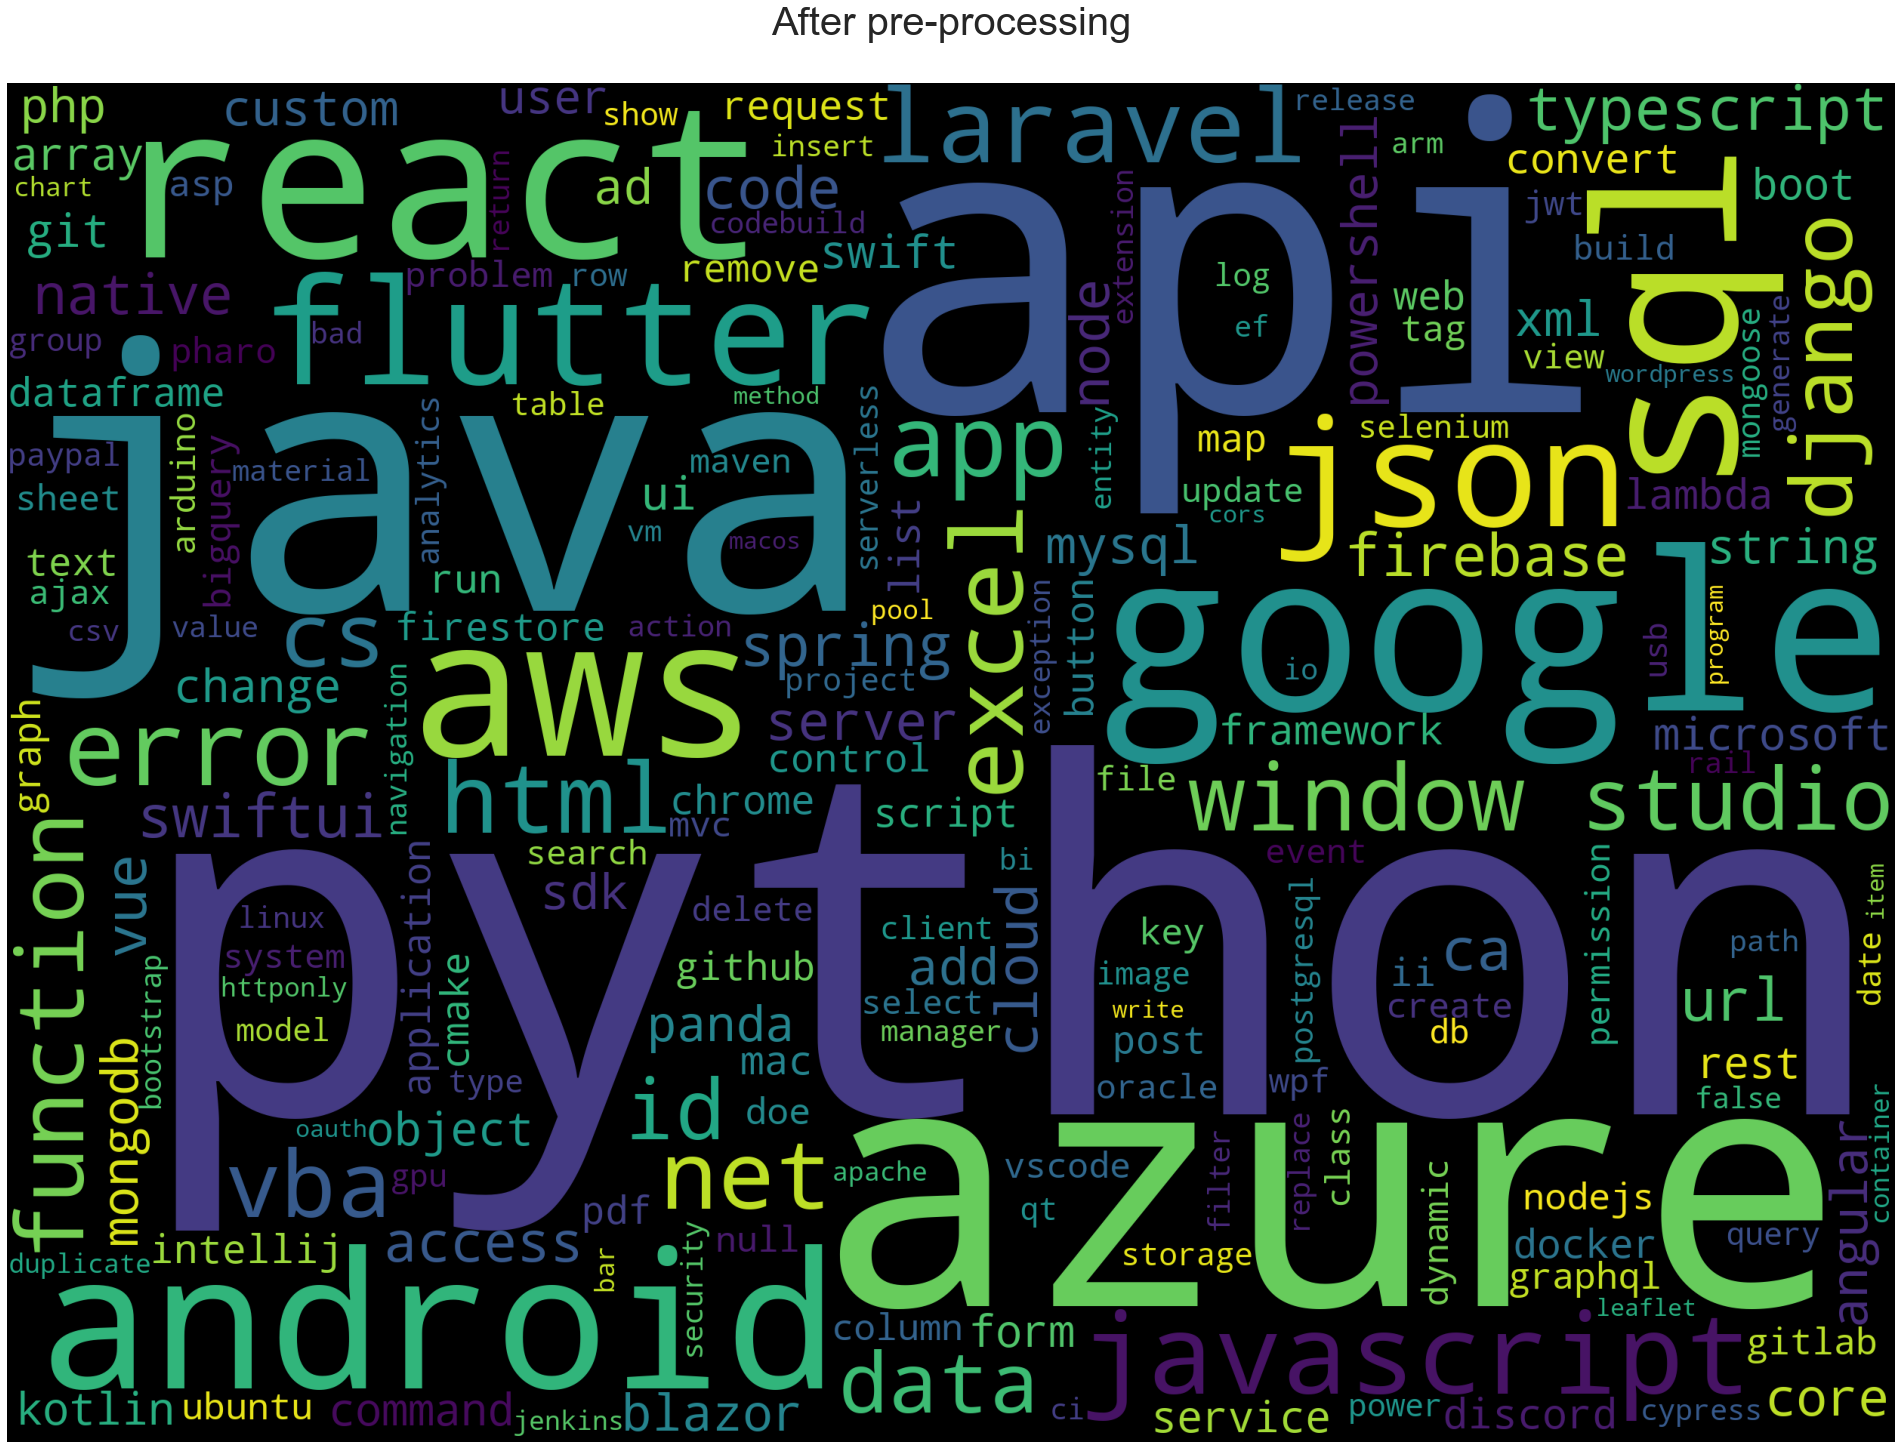

In [14]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

text = []
for i in data_words_nostops:
    text.append(' '.join(map(str, i))) # get all the words into one list

cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title('After pre-processing\n',fontsize=40)
plt.imshow(cloud_toxic)

It's seems that the data processing is working. Words as python, java, api etc. are frequent and for Stack Overflow these words are in theroy the most frequent. 

# Running Latent Dirichlet Allocation (LDA)

# Phrase Modeling: Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. 
Trigrams are 3 words frequently occurring.
Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more.
The two important arguments to Phrases are min_count and threshold.
The higher the values of these param, the harder it is for words to be combined.

In [15]:
# Bigrams/Trigrams
#=================
from gensim.models import Phrases

 # Add bigrams (if appears 10 times or more)
bigram = Phrases(data_words_nostops, min_count=10, threshold=100) # min_count: Ignore all words and bigrams with total 
                                                                  #            collected count lower than this value.
                                                                  # Threshold: Represent a score threshold for forming 
                                                                  #            the phrases (higher means fewer phrases). 

# Add trigrams (if appears 10 times or more)
trigram = Phrases(bigram[data_words_nostops], min_count=10, threshold=100) 

for idx in range(len(data_words_nostops)):
    for token in bigram[data_words_nostops[idx]]:
        if '_' in token:
            data_words_nostops[idx].append(token)  
    # Token is a bigram, add to document        
    for token in trigram[data_words_nostops[idx]]:
        if '_' in token:
            # Token is a trigram, add to document
            data_words_nostops[idx].append(token)

# Data Transformation: Corpus and Dictionary

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])
        # Gensim creates a unique id for each word in the document. 
        # The produced corpus shown below is a mapping of (word_id, word_frequency).
        # For example, (1, 2) implies, word id 1 occurs 2 times in the first document.
        # Likewise, word id 9 occurs 1 time in the second document

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1)]]


# Base Model

We have everything required to train the base LDA model.
In addition to the corpus and dictionary, I need to provide the number of topics as well. 
Here, I specify the number of topics as 10. Then, I will run a function in order to chose the optimal number of topics based on the best coherence score.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics.
According to the Gensim docs, both defaults to 1.0/num_topics prior (we’ll use default for the base model).

In [17]:
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100, 
                                       chunksize=100,#chunksize controls how many documents are processed at a time 
                                                           # in the training algorithm. Increasing chunksize will speed up 
                                                           # training, at least as long as the chunk of documents easily 
                                                           # fit into memory.
                                       passes=10, # how many times the algorithm is supposed to pass over the whole corpus
                                                   #passes controls how often we train the model on the entire corpus 
                                                  # (set to 10).
                                       per_word_topics=True)

# View the topics in LDA model and compute Coherence Score

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.
We can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics()

In [18]:
# Print the Keyword in the 10 topics
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.074*"react" + 0.063*"api" + 0.056*"android" + 0.027*"native" + '
  '0.023*"node" + 0.022*"blazor" + 0.022*"access" + 0.019*"mysql" + '
  '0.018*"panda" + 0.012*"change"'),
 (1,
  '0.038*"aws" + 0.037*"json" + 0.037*"error" + 0.032*"net" + 0.027*"swiftui" '
  '+ 0.025*"django" + 0.019*"xml" + 0.015*"framework" + 0.012*"string" + '
  '0.012*"map"'),
 (2,
  '0.110*"python" + 0.030*"window" + 0.029*"studio" + 0.027*"vba" + '
  '0.021*"angular" + 0.018*"spring" + 0.016*"excel" + 0.015*"boot" + '
  '0.013*"docker" + 0.012*"sdk"'),
 (3,
  '0.039*"typescript" + 0.034*"firebase" + 0.023*"powershell" + 0.021*"kotlin" '
  '+ 0.020*"git" + 0.016*"user" + 0.016*"intellij" + 0.016*"java" + '
  '0.014*"graphql" + 0.013*"create"'),
 (4,
  '0.074*"java" + 0.056*"flutter" + 0.050*"javascript" + 0.041*"html" + '
  '0.029*"function" + 0.022*"code" + 0.014*"json" + 0.013*"script" + '
  '0.012*"post" + 0.012*"web"'),
 (5,
  '0.046*"laravel" + 0.027*"cloud" + 0.023*"mongodb" + 0.021*"add" + '
  '0.

In [19]:
# Compute Coherence Score
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_nostops, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.7227229020130504


Topic Coherence: 'measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.'

# Hyperparameter Tuning on LDA model

Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:
- Number of Topics (K)
- Dirichlet hyperparameter alpha: Document-Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

PS: The hyperparameter tuning may take a wile that why I saved the results of the tunning in two dataframe:
lda_tuning_results_10_100.csv for the first tuning between 10 and 100 with a step of 10
lda_tuning_results_10_20.csv for the secong tuning between 10 and 20 with a step of 1

In [31]:
# Define the function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_nostops, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [28]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = list(np.arange(10, 100 + 1, 10))

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_10_100.csv', index=False)
    pbar.close()

 59%|███████████████████████████████████████████████▍                                | 320/540 [59:35<40:58, 11.17s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

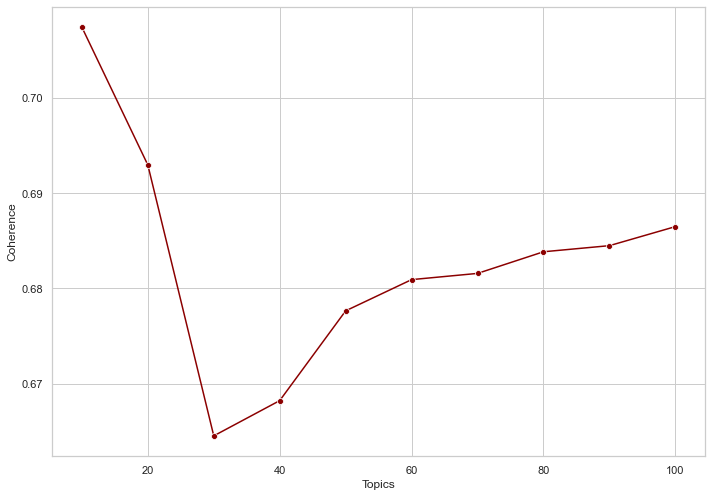

In [20]:
# Hyperparameter Tuning results
data_results = pd.read_csv('lda_tuning_results_10_100.csv', low_memory=False)

# Let's calculate the mean Coherence for each topic
mydata_results = data_results.groupby('Topics').agg({'Coherence':'mean'}).reset_index()

# Plot num_topics as function of Coherence
sns.lineplot(
    data=mydata_results,
    x="Topics", y="Coherence", color="darkred",
    marker='o', dashes=True
            )
                        # Coherence is maximal for number of Topics between 10 and 20 topics

The results show that Coherence is maximal for number of Topics between 10 and 20 topics. Let's refine the analysis in order to choose the optimal number of Topics.

In [32]:
# Refining of the Hyperparameter Tuning by running the analysis for number of topics between 10 and 20

import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
topics_range = list(np.arange(10, 20 + 1, 1))

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_10_20.csv', index=False)
    pbar.close()

 65%|████████████████████████████████████████████████████▏                           | 352/540 [54:34<29:08,  9.30s/it]


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

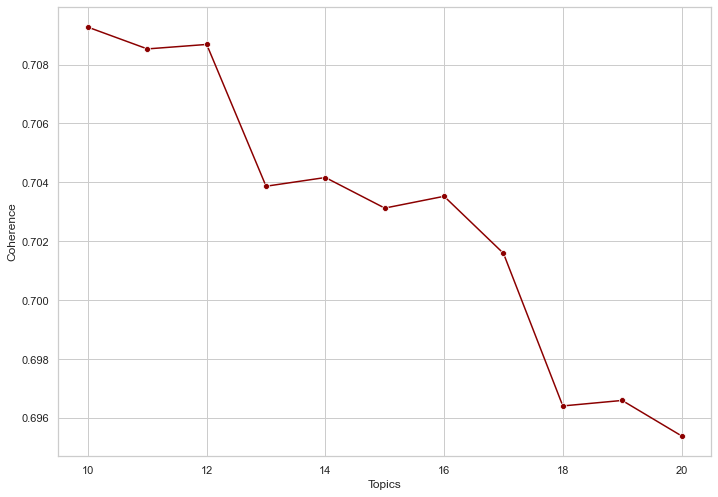

In [21]:
# Hyperparameter Tuning results
data_results = pd.read_csv('lda_tuning_results_10_20.csv', low_memory=False)

# Let's calculate the mean Coherence for each topic
mydata_results = data_results.groupby('Topics').agg({'Coherence':'mean'}).reset_index()

# Plot num_topics as function of Coherence
sns.lineplot(
    data=mydata_results,
    x="Topics", y="Coherence", color="darkred",
    marker='o', dashes=True
            )
# Coherence is maximal for number of Topics around 20 topics

In [22]:
# Group by Alpha for Topics = 12 
df = data_results[data_results['Topics']==12]

df_results = df.groupby('Alpha').agg(
    {   'Topics':'mean',
        'Coherence':'mean'
    }
).reset_index()
print(df_results)
print('-'*30)    

# Group by Beta for Topics = 10 
df_results = df.groupby('Beta').agg(
    {   'Topics':'mean',
        'Coherence':'mean'
    }
).reset_index()
print(df_results)
            # alpha = 0.31 and Beta = 0.1 has the highest Coherence score 

   Alpha  Topics  Coherence
0   0.01    12.0   0.719326
1   0.31    12.0   0.710538
2   0.61    12.0   0.686941
3   0.91    12.0   0.717931
------------------------------
   Beta  Topics  Coherence
0  0.01    12.0   0.736290
1  0.31    12.0   0.702556
2  0.61    12.0   0.690063
3  0.91    12.0   0.705827


The result of the hyperparemeters tunning shows that the highest Coherence score is around 0.72 for alpha = 0.31 and Beta = 0.01

# Final Model

In [20]:
# Let’s train the final model using the optimal hyper-parameters
import gensim
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.01)


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_nostops, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.7452721002507929


# Visualize Topics

In [21]:
# View top 12 words for each topic

num_topics=12
top_words=10

def get_lda_topics(model, num_topics, top_words):
    '''Function to return top words for num_topics'''
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = top_words);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

get_lda_topics(lda_model, num_topics, top_words)

Topic # 01 Topic # 02  Topic # 03  Topic # 04 Topic # 05 Topic # 06  \
0        api      azure      python  typescript       java        aws   
1    android      react        html   microsoft    flutter        sql   
2     status        net          ca    makefile     change    laravel   
3     access      error      native    intellij      array     lambda   
4     spring        xml      window       graph       post        run   
5        add     django         vba      vscode    request       text   
6       date   firebase       excel      delete    swiftui   mongoose   
7        web       node  powershell        file   function     oracle   
8  firestore         ad         csv         wpf     string       show   
9        mvc        php      kotlin    selenium    convert      chart   

   Topic # 07 Topic # 08 Topic # 09 Topic # 10  Topic # 11 Topic # 12  
0        core    angular        url     google  javascript       code  
1        data       json         id       http          cs      event  
2  postgresql      intel     blazor        vue      server     studio  
3      object      cloud     docker    problem         app       rest  
4        user    dynamic      mysql     github      nodejs        sdk  
5       write    command      build        doe     mongodb   generate  
6      script        log     custom        jwt        form      excel  
7    bigquery       load     chrome    cypress       class     module  
8     storage      swift      cmake         ui      update     webrtc  
9      entity   identity    control        git      insert        tag

C:\Users\adib_\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


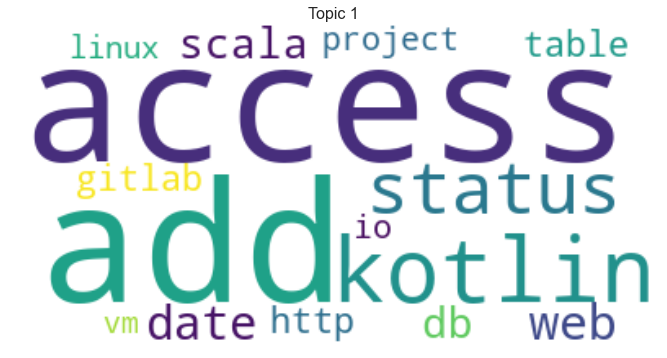

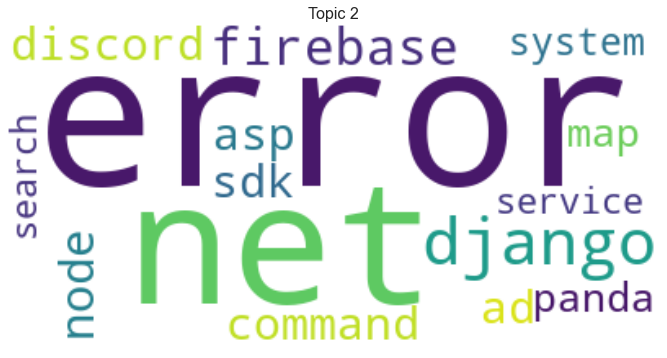

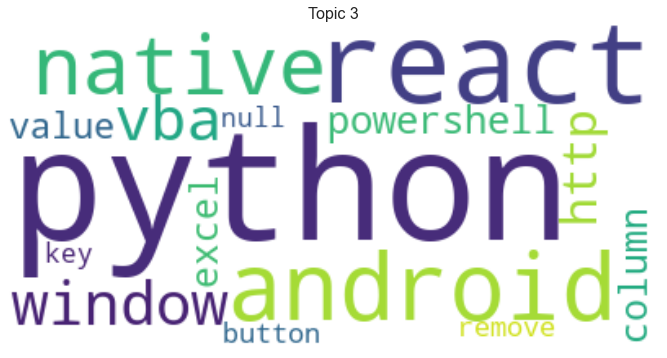

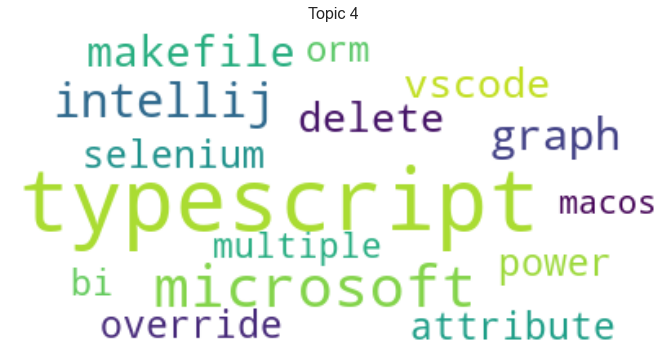

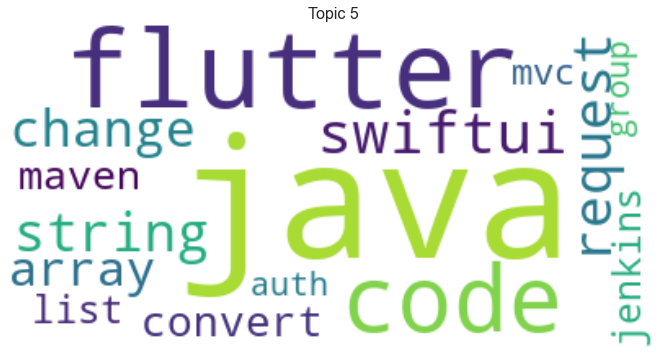

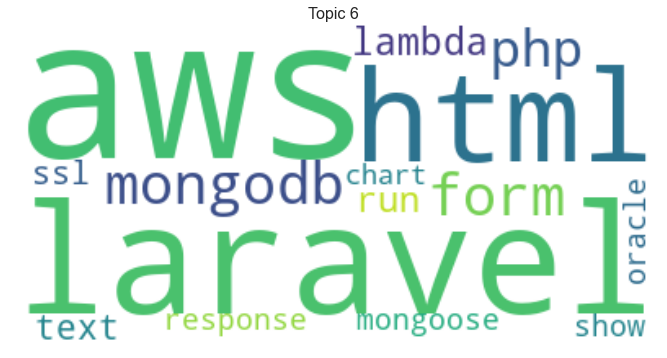

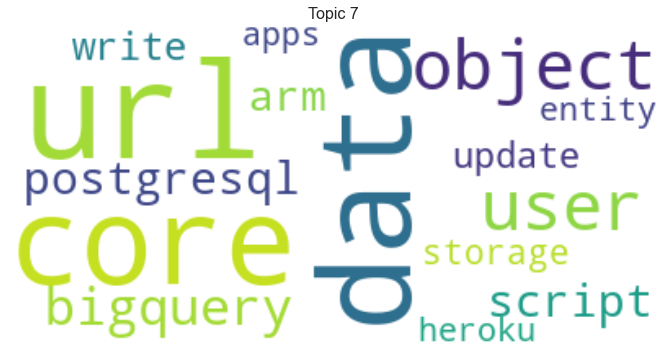

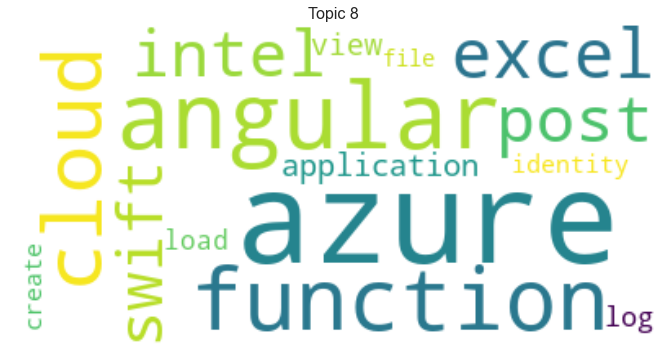

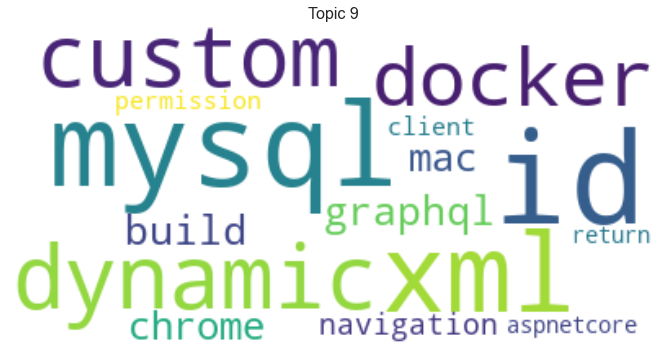

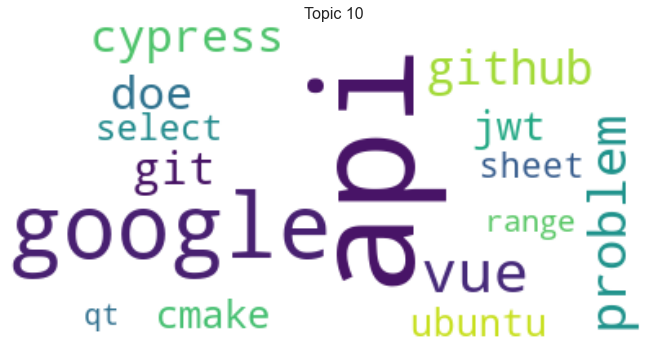

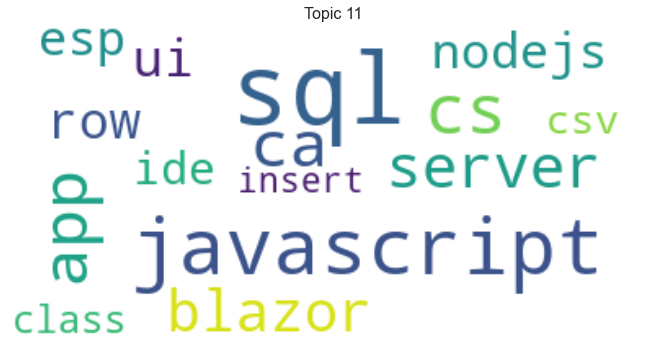

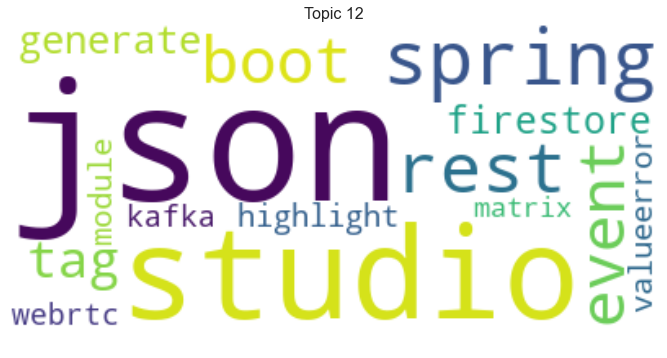

In [22]:
# Generate topic word clouds

from wordcloud import WordCloud

topic = 0 # Initialize counter
NUM_topics=12

while topic < NUM_topics:
    topic_words_freq = dict(lda_model.show_topic(topic, topn=15)) # select the top 15 words
    topic += 1    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.gca().set_title('Topic ' + str(topic), fontdict=dict(size=16))
    plt.axis("off")
    plt.show()

In [21]:
import pyLDAvis.gensim_models
import pickle
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

C:\Users\adib_\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.270704  0.255493       1        1  9.425913
7     -0.248584 -0.162370       2        1  8.739873
4      0.147183 -0.033714       3        1  8.534172
1     -0.131288 -0.295782       4        1  8.515356
9      0.038760  0.023024       5        1  8.489420
5      0.123335 -0.013646       6        1  8.377755
10     0.067680  0.002297       7        1  8.299730
8      0.051353  0.091566       8        1  8.220677
6      0.074741 -0.030252       9        1  7.998226
0     -0.042845  0.163318      10        1  7.960408
11     0.106886  0.004941      11        1  7.878197
3      0.083483 -0.004872      12        1  7.560273, topic_info=         Term        Freq       Total Category  logprob  loglift
2      python  137.000000  137.000000  Default  30.0000  30.0000
155      java  129.000000  129.000000  Default  29.0000  29.0000
50        api  104.000000  104.000000  Default  28.0000  28.0000
23     google   98.000000   98.000000  Default  27.0000  27.0000
217     azure  103.000000  103.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
415      idea    5.571215    5.726501  Topic12  -4.5603   2.5548
669    syntax    5.230892    5.385068  Topic12  -4.6234   2.5532
349       new    5.110876    5.267023  Topic12  -4.6466   2.5522
564    detect    4.638766    4.792870  Topic12  -4.7435   2.5496
227  pipeline    5.685954    5.886333  Topic12  -4.5400   2.5476

[409 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
140      10  0.996231   access
236       5  0.951787   action
262       4  1.010372       ad
16       10  1.005623      add
884      10  1.013874    allow
...     ...       ...      ...
702       8  0.906954    xcode
0         8  0.978177      xml
709      10  0.960820     yaml
285      10  0.961387  youtube
754       7  0.901050      zip

[388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 5, 2, 10, 6, 11, 9, 7, 1, 12, 4])

# Suggest tags from LDA topics

- Finding the dominant topics in each sentence:

One of the practical application of topic modeling is to determine what topic a given document is about.
To find that, I find the two topic numbers that has the highest percentage contribution in that document.
The format_topics_sentences() function below will aggregates this information in a dataframe.

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_nostops):
    # Init output
    sent_topics_df1 = pd.DataFrame()
    sent_topics_df2 = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, topn=100)
                topic_keywords = [word for word, prop in wp]
                sent_topics_df1 = sent_topics_df1.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            
            elif j==1: # => the second most dominant topic
                wp = ldamodel.show_topic(topic_num, topn=100)
                topic_keywords = [word for word, prop in wp]
                sent_topics_df2 = sent_topics_df2.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            
            else:
                break
    
    sent_topics_df = sent_topics_df1.join(sent_topics_df2, lsuffix='_First_topic', rsuffix='_Second_topic')
    
    # Add the text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Apply format_topics_sentences on my lda model
df_dominant_topic = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_nostops)

# Format
df_dominant_topic.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 
                             'Sec_Dominant_Topic', 'Sec_Perc_Contribution', 'Sec_Topic_Keywords', 'Text']

Here are the steps I followed to propose tags :
- I first take the words of topic 1 which are present in the initial text after processing
- I take the words of topic 2, that are present in the initial text, if the contribution of topic 2 exceeds a threshold of 0.1
- I add two common words on the both topics, if the contribution of topic 2 exceeds a threshold of 0.1 
- If the previous steps do not give anything I will add the top 3 words of the topic 1 

In [24]:
# Search the common words bewteen the dominant topic and the Text
#================================================================
Keywords1_Text = []

for i in range(0, len(df_dominant_topic)):
    Keywords1 = df_dominant_topic['Topic_Keywords'][i]
    Text = df_dominant_topic['Text'][i]
    Keywords1_Text.append([x for x in Keywords1 if x in Text])
    
df_dominant_topic['Keywords1_Text'] = Keywords1_Text # Add to df_dominant_topics



# Search the common words bewteen the second dominant topic and the Text only if the contribution 
# of the second dominant topic exceeds a threshold of 1
#================================================================================================
Keywords2_Text = []

for i in range(0, len(df_dominant_topic)):
    
    if df_dominant_topic['Sec_Perc_Contribution'][i]>0.1:
        Keywords2 = df_dominant_topic['Sec_Topic_Keywords'][i]
        Text = df_dominant_topic['Text'][i]
        Keywords2_Text.append([x for x in Keywords2 if x in Text])
        
    elif df_dominant_topic['Sec_Perc_Contribution'][i]<=0.1 :
        Keywords2_Text.append([])

df_dominant_topic['Keywords2_Text'] = Keywords2_Text # Add to df_dominant_topics



# Search the common words between topic 1 and 2
#==============================================
common_word = []

for i in range(0, len(df_dominant_topic)):
      
    if df_dominant_topic['Sec_Perc_Contribution'][i]>0.1:
        Keywords1 = df_dominant_topic['Topic_Keywords'][i]
        Keywords2 = df_dominant_topic['Sec_Topic_Keywords'][i]
        common_word.append([x for x in Keywords1 if x in Keywords2][:2])

    elif df_dominant_topic['Sec_Perc_Contribution'][i]<=0.1 :
        common_word.append([])

df_dominant_topic['Common_Word'] = common_word # Add to df_dominant_topics


# Add the words in a new column 'Tags'
#=====================================
df_dominant_topic['Tags'] = (df_dominant_topic['Keywords1_Text'] + 
                             df_dominant_topic['Keywords2_Text'] + 
                             df_dominant_topic['Common_Word'])

# avoid redundancy of words
new_list = []
for i in range(0, len(df_dominant_topic)):
    mylist = df_dominant_topic['Tags'][i]
    newlist = sorted(set(mylist), key=lambda x:mylist.index(x))
    new_list.append(newlist)


# Compare prediction to the real tag
df_LDA = df_sample.iloc[:,:2]
df_LDA['Tags_LDA'] = new_list
df_LDA.head(20)

Title  \
0   Grouping XML nodes based on the first element ...   
1   Connection error with SQL Server 2012 with Python   
2   I can't view WhatsApp media images in WhatsApp...   
3         How to use laravel-vue-pagination in Vue 3?   
4   Is this code clean (using policies, resources,...   
5                    Test api returns 201 instead 200   
6       post a model : the parent in the json or not?   
7                  Bootstrap 5 : toast without jquery   
8    Which syntax to use to translate in Blade files?   
9                            CORS issue with AdminLTE   
10             Vue.js 3 - How to use axios in main.js   
11         Does the notion of layout exist in vue.js?   
12      How to bind a v-model with a method in Vue.js   
13  How to init the store with data from the local...   
14              The "slot" component is not displayed   
15                             Laravel Dusk very slow   
16  Vue.js 3 - Trying to build a system with 2 lay...   
17                 Impossible to use vue-recaptcha-v3   
18      Problem to deploy a vue application in heroku   
19                 Add parameter to authorizeResource   

                                                 Tags  \
0                               <xml><xslt><grouping>   
1             <python><sql-server><python-3.x><linux>   
2             <android><image><filesystems><whatsapp>   
3                        <javascript><vue.js><vuejs3>   
4                                           <laravel>   
5                                           <laravel>   
6                                           <laravel>   
7                          <twitter-bootstrap><toast>   
8       <laravel><localization><laravel-localization>   
9                                          <adminlte>   
10                            <vue.js><axios><vuejs3>   
11                                           <vue.js>   
12                                   <vue.js><vuejs3>   
13  <javascript><vue.js><vuejs2><local-storage><vuex>   
14                   <javascript><vue.js><vue-router>   
15                            <laravel><laravel-dusk>   
16  <vue.js><vue-component><vue-router><vuejs3><vu...   
17                                   <vue.js><vuejs3>   
18                                   <vue.js><heroku>   
19                                          <laravel>   

                                      Tags_LDA  
0                                        [xml]  
1   [sql, server, connection, python, webpack]  
2                 [whatsapp, gallery, private]  
3                                        [vue]  
4                                           []  
5                                       [test]  
6                                           []  
7                                           []  
8                                      [blade]  
9            [cors, adminlte, release, spring]  
10                                       [vue]  
11                                          []  
12                                       [vue]  
13                                          []  
14                                          []  
15                                   [laravel]  
16                                       [vue]  
17                                          []  
18                                   [problem]  
19                                       [add]

By looking at the tags originally in stackoverflow and those from the LDA model, we can conclude that the unsupervised model seems to work for some questions. So let's save the model.

In [25]:
# Save the model
import joblib
joblib.dump(lda_model, 'lda_model.pkl')

['lda_model.pkl']

# Predict the topics for a new set of titles

In [26]:
# load the model
import joblib
lda_model_ = open('lda_model.pkl','rb')
lda = joblib.load(lda_model_)

In [27]:
# Load library
import re
import nltk
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords


# Load new set of data with questions from the 09/2021 to 10/2021
data_test = pd.read_csv('QueryResults_for_test.csv', low_memory=False)

# Then I took a sample of 20 row 
df_new_text = data_test.iloc[:20,[4, 5]].reset_index().drop(['index'], axis=1)

# Apply the same data processing
# Remove punctuation
df_new_text['Title_processed'] = df_new_text['Title'].map(lambda x: re.sub('[,\.!?]', ' ', x))

# Extract verbs, adverb etc.
def extract_NN(sent):
    grammar = r"""
    NP:
        {<NNP>} # proper noun, singular ex. 'Dupont'
        {<NNPS>} # proper noun, plural ex. 'Americans'        

    """
    chunker = nltk.RegexpParser(grammar)
    ne = []
    chunk = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
    for tree in chunk.subtrees(filter=lambda t: t.label() == 'NP'):
        ne.append(' '.join([child[0] for child in tree.leaves()]))
    return ne

df_new_text['Title_extracted'] = df_new_text.Title_processed.apply(extract_NN)

# Tokenize all words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_new_text.Title_extracted.tolist()
data_new_words = list(sent_to_words(data))

# Lemmatize all words
from nltk.stem.wordnet import WordNetLemmatizer

def Tags_preprocessor(Tags):
    
    # Lemmatize all words
    lemmatizer = WordNetLemmatizer()
    Tags = [[lemmatizer.lemmatize(token) for token in doc] for doc in Tags]
    return Tags

data_new_words = Tags_preprocessor(data_new_words)

# Remove Stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 'get', 'make', 'go', 'know', 
                   'take', 'see', 'come', 'think', 'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work', 
                   'seem', 'feel', 'try', 'leave', 'call', 'may','using'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data_new_words_nostops = remove_stopwords(data_new_words)


# Phrase Modeling: Bigram and Trigram Models

# Bigrams/Trigrams
#=================
from gensim.models import Phrases

 # Add bigrams (if appears 10 times or more)
bigram = Phrases(data_new_words_nostops, min_count=10, threshold=100) # min_count: Ignore all words and bigrams with total 
                                                                  #            collected count lower than this value.
                                                                  # Threshold: Represent a score threshold for forming 
                                                                  #            the phrases (higher means fewer phrases). 

# Add trigrams (if appears 10 times or more)
trigram = Phrases(bigram[data_new_words_nostops], min_count=10, threshold=100) 

for idx in range(len(data_new_words_nostops)):
    for token in bigram[data_new_words_nostops[idx]]:
        if '_' in token:
            data_new_words_nostops[idx].append(token)  
    # Token is a bigram, add to document        
    for token in trigram[data_new_words_nostops[idx]]:
        if '_' in token:
            # Token is a trigram, add to document
            data_new_words_nostops[idx].append(token)

            
# Data Transformation: Corpus and Dictionary
# Create Dictionary
id2word_new = corpora.Dictionary(data_new_words_nostops)

# Create Corpus
texts = data_new_words_nostops

# Term Document Frequency
corpus_new = [id2word_new.doc2bow(text) for text in texts]


# Fit the model by incrementally training on the new corpus.
lda.update(corpus_new)  # update the LDA model with additional documents

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df1 = pd.DataFrame()
    sent_topics_df2 = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, topn=100)
                topic_keywords = [word for word, prop in wp]
                sent_topics_df1 = sent_topics_df1.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                
            elif j==1:
                wp = ldamodel.show_topic(topic_num, topn=100)
                topic_keywords = [word for word, prop in wp]
                sent_topics_df2 = sent_topics_df2.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            
            else:
                break    
             
    sent_topics_df = sent_topics_df1.join(sent_topics_df2, lsuffix='_First_topic', rsuffix='_Second_topic')
    
    # Add the text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Apply format_topics_sentences on my lda model
df_dominant_topic_new = format_topics_sentences(ldamodel=lda, corpus=corpus_new, texts=data_new_words_nostops)

# Format
df_dominant_topic_new.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 
                                 'Sec_Dominant_Topic', 'Sec_Perc_Contribution', 'Sec_Topic_Keywords', 'Text']

In [28]:
# Search the common words bewteen the dominant topic and the Text
Keywords1_Text = []

for i in range(0, len(df_dominant_topic_new)):
    Keywords1 = df_dominant_topic_new['Topic_Keywords'][i]
    Text = df_dominant_topic_new['Text'][i]
    Keywords1_Text.append([x for x in Keywords1 if x in Text])
df_dominant_topic_new['Keywords1_Text'] = Keywords1_Text # Add the common words to the df_dominant_topic_news


# Search the common words bewteen the second dominant topic and the Text if the contribution > 1
Keywords2_Text = []

for i in range(0, len(df_dominant_topic_new)):
    
    if df_dominant_topic_new['Sec_Perc_Contribution'][i]>0.1:
        Keywords2 = df_dominant_topic_new['Sec_Topic_Keywords'][i]
        Text = df_dominant_topic_new['Text'][i]
        Keywords2_Text.append([x for x in Keywords2 if x in Text])
        
    elif df_dominant_topic_new['Sec_Perc_Contribution'][i]<=0.1 :
        Keywords2_Text.append([])
df_dominant_topic_new['Keywords2_Text'] = Keywords2_Text # Add the common words to the df_dominant_topic_news


# Search the common words between topic 1 and 2
common_word = []

for i in range(0,len(df_dominant_topic_new)):
    
    if df_dominant_topic_new['Sec_Perc_Contribution'][i]>0.1:
        Keywords1 = df_dominant_topic_new['Topic_Keywords'][i]
        Keywords2 = df_dominant_topic_new['Sec_Topic_Keywords'][i]
        common_word.append([x for x in Keywords1 if x in Keywords2][:3])

    elif df_dominant_topic_new['Sec_Perc_Contribution'][i]<=0.1 :
        common_word.append([])
df_dominant_topic_new['Common_Word'] = common_word # Add the common words to the df_dominant_topic_news


df_dominant_topic_new['Tags'] = (df_dominant_topic_new['Keywords1_Text'] + 
                             df_dominant_topic_new['Keywords2_Text'] + 
                             df_dominant_topic_new['Common_Word'])


new_liste = []
for i in range(0,len(df_dominant_topic_new)):
    mylist = df_dominant_topic_new['Tags'][i]
    newlist = sorted(set(mylist), key=lambda x:mylist.index(x))
    new_liste.append(newlist)

# Show the results of LDA predictions
df_test_lda = df_new_text.iloc[:,:2]
df_test_lda['Tags_LDA'] = new_liste
df_test_lda

Title  \
0   How can I get puppeteer objects from within a ...   
1       Why is jq modify and if-then-else not working   
2   Can GStreamer's rtspsrc element pass authentic...   
3          Remove a Layer from an AWS Lambda Function   
4   spring-webmvc/hibernate-validator not invalida...   
5   How to use local system fonts with wkhtml2pdf ...   
6   Unable to access DOM elements in component dur...   
7        Cannot query DOM from event handler in tests   
8   Populate a struct with an array of sub-structs...   
9   SQL Server and optimizing Common Table Expression   
10                               Sort ELBs by Traffic   
11  Gatsby Rewrite Slug with gatsby-node.js does n...   
12  With a JavaScript call stack and a .map file c...   
13  Using pytest coverage, is there a way to tell ...   
14  colab_utils.annotate() - the execution doesn't...   
15  How to debug unit test while developping a pac...   
16  How to increase the performance of multiple fi...   
17  How can I keep the old dark theme in Visual St...   
18  net50 Environment.GetFolderPath(Environment.Sp...   
19  CSS Media Queries for Xbox Edge Browser and VR...   

                                                 Tags  \
0          <node.js><sapui5><puppeteer><karma-runner>   
1                                                <jq>   
2                                         <gstreamer>   
3   <amazon-web-services><aws-lambda><aws-sdk><aws...   
4             <java><spring-mvc><hibernate-validator>   
5                            <css><fonts><wkhtml2pdf>   
6     <reactjs><jestjs><react-testing-library><jsdom>   
7            <reactjs><jestjs><react-testing-library>   
8                                                <go>   
9                                   <sql><sql-server>   
10                     <amazon-web-services><aws-elb>   
11                                           <gatsby>   
12       <javascript><node.js><typescript><debugging>   
13  <python><unit-testing><pytest><coverage.py><py...   
14  <tensorflow><jupyter-notebook><google-colabora...   
15                        <visual-studio-code><julia>   
16                                 <php><performance>   
17  <visual-studio><themes><visual-studio-2022><da...   
18  <macos><environment-variables><.net-5><applica...   
19        <css><media-queries><virtual-reality><xbox>   

                       Tags_LDA  
0                            []  
1                            []  
2        [webpack, python, vba]  
3   [aws, sql, javascript, app]  
4                            []  
5                            []  
6                            []  
7                            []  
8                            []  
9     [sql, json, azure, error]  
10            [spring, release]  
11                           []  
12                           []  
13                           []  
14                           []  
15                           []  
16                           []  
17                           []  
18      [google, sheet, method]  
19    [control, webpack, check]

On the unknwon data the model seems to not work well 

# Negative Matrix Factorisation (NMF)

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

cf. https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45 for more information.

# Base Model

To run the NMF, I need to provide the number of topics. 
Here, I specify the number of topics as 10. Then, I will run a function in order to chose the optimal number of topics based on the best coherence score.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

# NMF is able to use tf-idf
documents = []
for i in data_words_nostops:
    documents.append(' '.join(map(str, i)))

# Calculate tfidf
tfidf_vectorizer = TfidfVectorizer(min_df=3, # ignores terms whose document frequency is less than 3
                                    max_df=0.85, # ignores terms whose document frequency is greater than 85%
                                    max_features=5000,
                                    ngram_range=(1,1) # it allows us to choose a range of word lengths, I’m sticking with 1 word
                                    )
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


# Run NMF
nmf = NMF(n_components=10,
          alpha=.1, 
          l1_ratio=.5,
          init='nndsvd'
         ).fit(tfidf)


# Display the first 15 words of each topic
def display_topics(model, feature_names, no_top_words):# define a function that allow to display the most frequent words in each topic 
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0:
python panda dataframe error list http result request csv selenium
Topic 1:
java jooq change ca window scala stream cmd thread rhino
Topic 2:
react native typescript android hook component show app mysql firebase
Topic 3:
javascript html cs error url code object array intellij map
Topic 4:
api azure rest management vue graph web aws microsoft ad
Topic 5:
laravel cs django id mongodb chrome ii vue permission webpack
Topic 6:
google cloud script sheet play run app pdf function hide
Topic 7:
sql server select pl azure column oracle connection php data
Topic 8:
flutter firebase listview string text container error data http graphql
Topic 9:
json swift convert bigquery html system array xml mvc invalid


# Topics Tuning on NMF

To chose the best number of topics, I can use the coherence score. Sklearn’s NMF implementation does not have a coherence score but gensim's NMF implementation does. Another limitation is that sklearn’s implementation of NMF can use tf-idf weights. 

Therefore, to find the optimal number of topics, I’ll use gensim to get the best number of topics with the coherence score and then use that number of topics for the sklearn implementation of NMF with tfidf.

In [30]:
import gensim.corpora as corpora
from gensim.models import Nmf
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from operator import itemgetter

In [31]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = data_words_nostops

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = corpora.Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(10, 30 + 1, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)
print(f'The best number of topics is: {best_num_topics[0][0]}\n\n{best_num_topics}')

The best number of topics is: 12

[(12, 0.65112), (23, 0.64644), (10, 0.64414), (22, 0.64227), (30, 0.64138), (14, 0.64016), (13, 0.63949), (11, 0.63829), (21, 0.63749), (19, 0.63731), (25, 0.63689), (24, 0.63591), (15, 0.63474), (27, 0.63468), (17, 0.63399), (29, 0.63256), (28, 0.63252), (18, 0.62675), (26, 0.62532), (16, 0.62281), (20, 0.62194)]


As for LDA the optimal number of topics for NMF is also 12

# Final model

In [32]:
nmf_model = NMF(n_components=12,
          alpha=0.1, 
          l1_ratio=0.5,
          init='nndsvd'
         ).fit(tfidf)

In [33]:
# Save the nmf model and tfidf
import joblib
joblib.dump(nmf_model, 'nmf_model.pkl')

joblib.dump(tfidf_vectorizer, 'nmf_tfidf.pkl')

['nmf_tfidf.pkl']

# Predict topics on new data

- Load and process new data

In [34]:
# load the model
import joblib
nmf_ = open('nmf_model.pkl','rb')
nmf = joblib.load(nmf_)

tfidf_ = open('nmf_tfidf.pkl','rb')
tfidf_vectorizer = joblib.load(tfidf_)

In [35]:
# Test the model on the 20 new questins selected above

# Process the data
# Load library
import re
import nltk
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords


# Remove punctuation
df_new_text['Title_processed'] = df_new_text['Title'].map(lambda x: re.sub('[,\.!?]', ' ', x))

# Extract verbs, adverb etc.
def extract_NN(sent):
    grammar = r"""
    NP:
        {<NNP>} # proper noun, singular ex. 'Dupont'
        {<NNPS>} # proper noun, plural ex. 'Americans'
    """
    chunker = nltk.RegexpParser(grammar)
    ne = []
    chunk = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
    for tree in chunk.subtrees(filter=lambda t: t.label() == 'NP'):
        ne.append(' '.join([child[0] for child in tree.leaves()]))
    return ne

df_new_text['Title_extracted'] = df_new_text.Title_processed.apply(extract_NN)


# Tokenize all words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df_new_text.Title_extracted.tolist()

data_new_words = list(sent_to_words(data))


# Lemmatize all words
from nltk.stem.wordnet import WordNetLemmatizer

def Tags_preprocessor(Tags):
    lemmatizer = WordNetLemmatizer()
    Tags = [[lemmatizer.lemmatize(token) for token in doc] for doc in Tags]
    return Tags

data_new_words = Tags_preprocessor(data_new_words)


# Remove Stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 'get', 'make', 'go', 'know', 
                   'take', 'see', 'come', 'think', 'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work', 
                   'seem', 'feel', 'try', 'leave', 'call'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data_new_words_nostops = remove_stopwords(data_new_words)


# Calculate tfidf
df_new_text['processed_text'] = data_new_words_nostops
df_new_text.head()

new_documents = []
for i in df_new_text['processed_text']:
    new_documents.append(' '.join(map(str, i)))
    
tfidf_new = tfidf_vectorizer.transform(new_documents)
tfidf_new_feature_names = tfidf_vectorizer.get_feature_names()

# Fit nmf on the new data
X_new = nmf.transform(tfidf_new)

In [36]:
# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new] # dominant text
predicted_topics_2 = [np.argsort(each)[::-1][1] for each in X_new] # second dominant text

# Add to the df
df_new_text['pred_topic_num'] = predicted_topics
df_new_text['pred_topic_num2'] = predicted_topics_2


# Display the first most frequent words of each topic
words_of_topic = []

def display_topics(model, feature_names, no_top_words):# define a function that allow to display the most frequent words in each topic 
    for topic_idx, topic in enumerate(model.components_):
        words_of_topic.append([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

no_top_words = 100
display_topics(nmf, tfidf_new_feature_names, no_top_words)


# Select the first and the second dominant topics
words_topic1 = []
for i in df_new_text.loc[:, 'pred_topic_num']:
    words_topic1.append(words_of_topic[i])

words_topic2 = []
for i in df_new_text.loc[:, 'pred_topic_num2']:
    words_topic2.append(words_of_topic[i])
    
df_new_text['pred_topic_words'] = words_topic1
df_new_text['pred_topic_words2'] = words_topic2

In [37]:
# Search the common words bewteen the most dominant topic and the Text
Keywords1_Text = []

for i in range(0, len(df_new_text)):
    Keywords1 = df_new_text['pred_topic_words'][i]
    Text = df_new_text['processed_text'][i]
    Keywords1_Text.append([x for x in Keywords1 if x in Text])
df_new_text['Keywords1_Text'] = Keywords1_Text # Add the common words to the df_dominant_topic_news


# Search the common words bewteen the second dominant topic and the Text
Keywords2_Text = []

for i in range(0, len(df_new_text)):
    Keywords2 = df_new_text['pred_topic_words2'][i]
    Text = df_new_text['processed_text'][i]
    Keywords2_Text.append([x for x in Keywords2 if x in Text])
df_new_text['Keywords2_Text'] = Keywords2_Text # Add the common words to the df_dominant_topic_news

# Search the common words between topic 1 and 2
common_word = []

for i in range(0,len(df_new_text)):
    
    Keywords1 = df_new_text['pred_topic_words'][i]
    Keywords2 = df_new_text['pred_topic_words2'][i]
    common_word.append([x for x in Keywords1 if x in Keywords2][:2])

df_new_text['Common_Word'] = common_word # Add the common words to the df_dominant_topic_news


# Proposed tags
df_new_text['Tags_nmf'] = (df_new_text['Keywords1_Text'] + 
                             df_new_text['Keywords2_Text'] + 
                             df_new_text['Common_Word'])

new_liste = []
for i in range(0,len(df_new_text)):
    mylist = df_new_text['Tags_nmf'][i]
    newlist = sorted(set(mylist), key=lambda x:mylist.index(x))
    new_liste.append(newlist)

# Show the results of NMD predictions
df_nmf = df_new_text.iloc[:,:2]
df_nmf['Tags_NMF'] = new_liste
df_nmf

Title  \
0   How can I get puppeteer objects from within a ...   
1       Why is jq modify and if-then-else not working   
2   Can GStreamer's rtspsrc element pass authentic...   
3          Remove a Layer from an AWS Lambda Function   
4   spring-webmvc/hibernate-validator not invalida...   
5   How to use local system fonts with wkhtml2pdf ...   
6   Unable to access DOM elements in component dur...   
7        Cannot query DOM from event handler in tests   
8   Populate a struct with an array of sub-structs...   
9   SQL Server and optimizing Common Table Expression   
10                               Sort ELBs by Traffic   
11  Gatsby Rewrite Slug with gatsby-node.js does n...   
12  With a JavaScript call stack and a .map file c...   
13  Using pytest coverage, is there a way to tell ...   
14  colab_utils.annotate() - the execution doesn't...   
15  How to debug unit test while developping a pac...   
16  How to increase the performance of multiple fi...   
17  How can I keep the old dark theme in Visual St...   
18  net50 Environment.GetFolderPath(Environment.Sp...   
19  CSS Media Queries for Xbox Edge Browser and VR...   

                                                 Tags  \
0          <node.js><sapui5><puppeteer><karma-runner>   
1                                                <jq>   
2                                         <gstreamer>   
3   <amazon-web-services><aws-lambda><aws-sdk><aws...   
4             <java><spring-mvc><hibernate-validator>   
5                            <css><fonts><wkhtml2pdf>   
6     <reactjs><jestjs><react-testing-library><jsdom>   
7            <reactjs><jestjs><react-testing-library>   
8                                                <go>   
9                                   <sql><sql-server>   
10                     <amazon-web-services><aws-elb>   
11                                           <gatsby>   
12       <javascript><node.js><typescript><debugging>   
13  <python><unit-testing><pytest><coverage.py><py...   
14  <tensorflow><jupyter-notebook><google-colabora...   
15                        <visual-studio-code><julia>   
16                                 <php><performance>   
17  <visual-studio><themes><visual-studio-2022><da...   
18  <macos><environment-variables><.net-5><applica...   
19        <css><media-queries><virtual-reality><xbox>   

                                Tags_NMF  
0                              [eks, ec]  
1                              [eks, ec]  
2                              [eks, ec]  
3           [aws, lambda, function, eks]  
4                              [eks, ec]  
5                              [eks, ec]  
6                              [eks, ec]  
7                              [eks, ec]  
8                              [eks, ec]  
9   [sql, server, table, access, insert]  
10                             [eks, ec]  
11                             [eks, ec]  
12        [javascript, typescript, html]  
13                             [eks, ec]  
14                             [eks, ec]  
15                             [eks, ec]  
16                             [eks, ec]  
17                    [studio, firebase]  
18                             [eks, ec]  
19                      [cs, error, url]

The NMF works seems to work well. However, for some questions the model forces the prediction of the same tag instead of predicting nothing.